# Курсовой проект по теме "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

* [Загрузка данных](#loads)
* [1. EDA](#edas)
* [2. Обработка выбросов](#outliers)
* [3. Обработка пропусков](#nans)
* [4. Построение новых признаков](#features)
* [5. Разбиение на train и test](#splits)
* [6. Построение модели](#models)
* [7. Прогнозирование на тестовом датасете](#prediction)

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import mutual_info_regression
from category_encoders import MEstimateEncoder
from scipy.stats import mode

%matplotlib inline
%config InlineBackend.figure_format='svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 4)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 4)))
    
    plt.figure(figsize=(9,5))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [3]:
def out_iqr(df , column):
    # global lower,upper
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    # calculate the IQR
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    # calculate the lower and upper bound value
    lower, upper = q25 - cut_off, q75 + cut_off
    print('The IQR is',iqr)
    print('The lower bound value is', lower)
    print('The upper bound value is', upper)
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    return print('Total number of outliers are', df1.shape[0]+ df2.shape[0])

In [4]:
 def me_encode(X_me, y_me, df, cols, m):
        encoder = MEstimateEncoder(cols=cols, m=m)
        encoder.fit(X_me, y_me)
        return encoder.transform(df)

In [5]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=42)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [6]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

### Пути к директориям и файлам

In [7]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

## Загрузка данных <a class='anchor' id='loads'>

#### Описание датасета

#### Data fields  
**Id** - идентификационный номер квартиры  
**DistrictId** - идентификационный номер района  
**Rooms** - количество комнат  
**Square** - площадь  
**LifeSquare** - жилая площадь  
**KitchenSquare** - площадь кухни  
**Floor** - этаж  
**HouseFloor** - количество этажей в доме  
**HouseYear** - год постройки дома  
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности  
**Social_1, Social_2, Social_3** - социальные показатели местности  
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья  
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров  
**Price** - цена квартиры

In [8]:
df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [9]:
df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

### Приведение типов

In [10]:
df['DistrictId'] = df['DistrictId'].astype(str)

## EDA <a class='anchor' id='edas'>

#### Целевая переменная

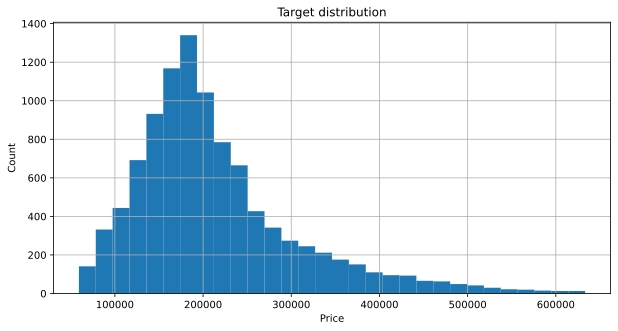

In [11]:
plt.figure(figsize = (10, 5))

df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [12]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Категориальные переменные

In [13]:
df.select_dtypes(include='object').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [14]:
df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
209      1
196      1
117      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [15]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Обработка выбросов <a class='anchor' id='outliers'>

#### Rooms

In [18]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [19]:
df.loc[(df['Rooms'] > 5) | (df['Rooms'] == 0), 'Rooms'] = df['Rooms'].mode()[0]

In [20]:
df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

In [21]:
out_iqr(df, 'Square')

The IQR is 24.125744426186976
The lower bound value is 5.586264180189367
The upper bound value is 102.08924188493728
Total number of outliers are 242


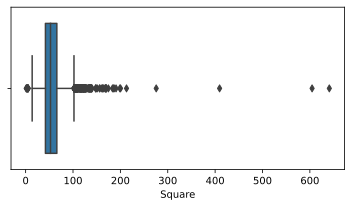

In [22]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [23]:
df.loc[(df['Square'] > 300) | (df['Square'] < 6)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
28,9,2.0,604.705972,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.242538
9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083
11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764


In [24]:
df.loc[(df['Square'] > 300) | (df['Square'] < 6), 'Square'] = df['Square'].median()

#### Floor

In [25]:
df['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

In [26]:
df['Floor'].nunique()

33

In [27]:
df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

In [28]:
df.loc[df['HouseFloor'] > 50]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515


In [29]:
df.loc[df['HouseFloor'] > 50, 'HouseFloor'] = df['HouseFloor'].mode()[0]

#### HouseYear

In [30]:
df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [31]:
df.loc[df['HouseYear'] > 2020, 'HouseYear'] = df['HouseYear'].mode()[0]

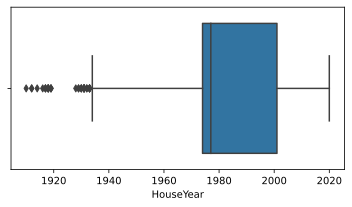

In [32]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['HouseYear'], whis=1.5)

plt.xlabel('HouseYear')
plt.show()

#### Ecology_1

In [33]:
df['Ecology_1'].value_counts()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.014334      1
0.012522      1
Name: Ecology_1, Length: 129, dtype: int64

#### Social_1, Social_2, Social_3

In [34]:
df['Social_1'].value_counts()

2     688
1     654
25    557
5     528
30    465
23    434
6     377
22    367
53    355
34    311
33    252
46    245
31    243
43    238
9     213
36    209
21    207
37    205
24    205
52    201
0     201
35    200
47    177
74    176
39    159
27    151
28    144
4     141
11    138
42    129
26    127
16    123
19    118
66     99
17     96
49     95
18     92
32     87
41     83
50     79
29     70
38     64
8      62
15     51
20     50
14     46
10     24
13     22
12     18
7      15
3       9
Name: Social_1, dtype: int64

In [35]:
df['Social_1'].nunique()

51

In [36]:
df['Social_2'].value_counts()

264     587
1564    511
629     486
1437    346
6398    245
       ... 
1423      3
568       3
662       2
507       1
528       1
Name: Social_2, Length: 142, dtype: int64

In [37]:
df['Social_3'].value_counts()

0      2997
1      1861
3      1136
4       835
2       635
6       423
5       391
141     245
9       192
7       184
11      172
8       170
10      142
16      101
14       97
27       59
48       58
56       49
84       43
24       37
87       27
93       25
59       25
19       22
20       19
23       18
39       15
73       10
45        9
37        3
Name: Social_3, dtype: int64

#### Healthcare_1, Helthcare_2

In [38]:
df['Healthcare_1'].value_counts()

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [39]:
df['Helthcare_2'].value_counts()

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64

#### Shops_1

In [40]:
df['Shops_1'].value_counts()

0     2316
1     1325
5     1324
2      964
4      841
3      711
6      487
11     401
9      316
7      294
8      253
23     245
10     215
15     176
16      83
19      49
Name: Shops_1, dtype: int64

## Обработка пропусков <a class='anchor' id='nans'>

In [41]:
df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### LifeSquare

In [42]:
df['LifeSquare_nan'] = 0
df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

In [43]:
# Удаляем LifeSquare
df.drop('LifeSquare', axis=1, inplace=True)

#### Healthcare_1

In [44]:
df['Healthcare_1_nan'] = 0

In [45]:
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

In [46]:
df['Healthcare_1'].fillna(0, inplace=True)

In [47]:
class DataPreprocessing:
    
    def __init__(self):
        
        self.medians = None
        self.modes = None
        
    def fit(self, X):
        
        self.medians = X.median()
        self.modes = pd.DataFrame(mode(X)[0], columns=X.columns)
        
    def transform(self, X):
        
        # Rooms
        X.loc[(X['Rooms'] > 5) | (X['Rooms'] == 0), 'Rooms'] = self.modes['Rooms'][0]
        
        # Square
        X.loc[(X['Square'] > 300) | (X['Square'] < 6), 'Square'] = self.medians['Square']
        
        # HouseFloor
        X.loc[X['HouseFloor'] > 50, 'HouseFloor'] = self.modes['HouseFloor'][0]
        
        # HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = self.modes['HouseYear'][0]
        
        # LifeSquare
        X['LifeSquare_nan'] = 0
        X.loc[X['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        X.drop('LifeSquare', axis=1, inplace=True)
        
        # Healthcare_1
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        X['Healthcare_1'].fillna(0, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

## Построение новых признаков <a class='anchor' id='features'>

In [48]:
# Binary features
df['Ecology_2'] = df['Ecology_2'].replace({'A': 0, 'B': 1})
df['Ecology_3'] = df['Ecology_3'].replace({'A': 0, 'B': 1})
df['Shops_2'] = df['Shops_2'].replace({'A': 0, 'B': 1})

In [49]:
# HouseYear to Age
df['HouseYear'] = 2020 - df['HouseYear']

In [50]:
# Удаляем KitchenSquare
df.drop('KitchenSquare', axis=1, inplace=True)

In [51]:
# Rooms to RoomSquare
df['RoomSquare'] = df['Square'] / df['Rooms']
df.drop('Rooms', axis=1, inplace=True)

#### Mutual Information

In [52]:
# Помечаем дискретные признаки для функции. Для этого переводим их в тип 'object'.
# Это бинарные признаки и признаки, которые далее будут преобразованы с помощью target encoding.
features = ['Ecology_2', 'Ecology_3', 'Shops_2', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2']
df[features] = df[features].astype(str)

In [53]:
df.drop('Price', axis=1).dtypes

DistrictId           object
Square              float64
Floor                 int64
HouseFloor          float64
HouseYear             int64
Ecology_1           float64
Ecology_2            object
Ecology_3            object
Social_1             object
Social_2             object
Social_3             object
Healthcare_1         object
Helthcare_2          object
Shops_1               int64
Shops_2              object
LifeSquare_nan        int64
Healthcare_1_nan      int64
RoomSquare          float64
dtype: object

In [54]:
# Сообщаем функции, какие признаки являются дискретными (object), а какие - нет.
features = df.drop('Price', axis=1).dtypes == object
mi_scores = make_mi_scores(df.drop('Price', axis=1), df['Price'], discrete_features=features)
mi_scores

Social_2            0.344354
Square              0.323535
DistrictId          0.303981
Social_1            0.228417
Ecology_1           0.208334
RoomSquare          0.202670
Healthcare_1        0.149327
HouseYear           0.134285
Shops_1             0.109537
Social_3            0.104787
HouseFloor          0.082076
Helthcare_2         0.073355
LifeSquare_nan      0.029577
Floor               0.026023
Healthcare_1_nan    0.022574
Shops_2             0.007874
Ecology_3           0.004580
Ecology_2           0.001500
Name: MI Scores, dtype: float64

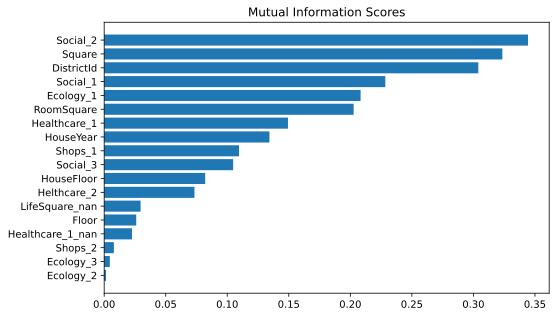

In [55]:
plt.figure(figsize=(8, 5))
plot_mi_scores(mi_scores)

In [56]:
# Удаляем признак Ecology_3 из-за минимального влияния на целевую переменную, Ecology_2 будет использован для target encoding'а:
df.drop('Ecology_3', axis=1, inplace=True)

### Target Encoding

In [57]:
X = df.drop('Price', axis=1)
y = df['Price']

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [59]:
# Чтобы сократить переобучение после target encoding'а, выделим только часть тренировочных данных для кодирования:
X_encode = X_train.sample(frac=0.33, random_state=42)
y_encode = y_train[X_encode.index]

In [60]:
df.nunique()

DistrictId            205
Square               9986
Floor                  33
HouseFloor             42
HouseYear              95
Ecology_1             129
Ecology_2               2
Social_1               51
Social_2              142
Social_3               30
Healthcare_1           79
Helthcare_2             7
Shops_1                16
Shops_2                 2
Price               10000
LifeSquare_nan          2
Healthcare_1_nan        2
RoomSquare           9988
dtype: int64

#### DistrictId

In [61]:
X_train = me_encode(X_me=X_encode, y_me=y_encode, df=X_train, cols=['DistrictId'], m=1.0)
X_valid = me_encode(X_me=X_encode, y_me=y_encode, df=X_valid, cols=['DistrictId'], m=1.0)

#### Social_2

In [62]:
X_train = me_encode(X_me=X_encode, y_me=y_encode, df=X_train, cols=['Social_2'], m=1.0)
X_valid = me_encode(X_me=X_encode, y_me=y_encode, df=X_valid, cols=['Social_2'], m=1.0)

#### Social_1

In [63]:
X_train = me_encode(X_me=X_encode, y_me=y_encode, df=X_train, cols=['Social_1'], m=7.0)
X_valid = me_encode(X_me=X_encode, y_me=y_encode, df=X_valid, cols=['Social_1'], m=7.0)

#### Social_3

In [64]:
X_train = me_encode(X_me=X_encode, y_me=y_encode, df=X_train, cols=['Social_3'], m=3.0)
X_valid = me_encode(X_me=X_encode, y_me=y_encode, df=X_valid, cols=['Social_3'], m=3.0)

#### Healthcare_1

In [65]:
X_train = me_encode(X_me=X_encode, y_me=y_encode, df=X_train, cols=['Healthcare_1'], m=2.0)
X_valid = me_encode(X_me=X_encode, y_me=y_encode, df=X_valid, cols=['Healthcare_1'], m=2.0)

#### Helthcare_2

In [66]:
X_train = me_encode(X_me=X_encode, y_me=y_encode, df=X_train, cols=['Helthcare_2'], m=1.0)
X_valid = me_encode(X_me=X_encode, y_me=y_encode, df=X_valid, cols=['Helthcare_2'], m=1.0)

In [67]:
class FeatureGenerator():
    
    def __init__(self):
        
        self.binary_to_numbers = None
        self.X_encode = None
        self.y_encode = None
    
    def fit(self, X, y):
        
        X = X.copy()
        self.X_encode = X.sample(frac=0.33, random_state=42)
        self.y_encode = y[self.X_encode.index]
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # HouseYear -> Age
        X['HouseYear'] = 2020 - X['HouseYear']
        
        # Target encoding
        X = me_encode(X_me=self.X_encode, y_me=self.y_encode, df=X, cols=['DistrictId'], m=1.0)
        X = me_encode(X_me=self.X_encode, y_me=self.y_encode, df=X, cols=['Social_1'], m=7.0)
        X = me_encode(X_me=self.X_encode, y_me=self.y_encode, df=X, cols=['Social_2'], m=1.0) 
        X = me_encode(X_me=self.X_encode, y_me=self.y_encode, df=X, cols=['Social_3'], m=3.0)
        X = me_encode(X_me=self.X_encode, y_me=self.y_encode, df=X, cols=['Helthcare_2'], m=1.0) 
        X = me_encode(X_me=self.X_encode, y_me=self.y_encode, df=X, cols=['Healthcare_1'], m=2.0)
        
        # Rooms -> RoomSquare
        X['RoomSquare'] = X['Square'] / X['Rooms']
        
        # Dropping features
        X.drop(['KitchenSquare', 'Ecology_3', 'Rooms'], axis=1, inplace=True)
         
        return X

## Разбиение на train и test <a class='anchor' id='splits'>

In [68]:
target_name = 'Price'

In [69]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')

X = train_df.drop(target_name, axis=1)
y = train_df[target_name]

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [71]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 19), (2500, 19), (5000, 19))

In [72]:
feature_gen = FeatureGenerator()
feature_gen.fit(X_train, y_train)

X_train = feature_gen.transform(X_train)
X_valid = feature_gen.transform(X_valid)
test_df = feature_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 17), (2500, 17), (5000, 17))

## Построение модели <a class='anchor' id='models'>

#### Обучение

In [73]:
model = GradientBoostingRegressor(max_features='sqrt', 
                                  loss='huber',
                                  random_state=42, 
                                  learning_rate=0.02,
                                  max_depth=8,  
                                  min_samples_leaf=40,
                                  n_estimators=1350,
                                  init=GradientBoostingRegressor(n_estimators=80, random_state=42))

In [74]:
model.fit(X_train, y_train)

GradientBoostingRegressor(init=GradientBoostingRegressor(n_estimators=80,
                                                         random_state=42),
                          learning_rate=0.02, loss='huber', max_depth=8,
                          max_features='sqrt', min_samples_leaf=40,
                          n_estimators=1350, random_state=42)

#### Оценка модели

In [75]:
y_pred_train = model.predict(X_train)

In [76]:
y_pred_valid = model.predict(X_valid)

Train R2:	0.8641
Test R2:	0.7712


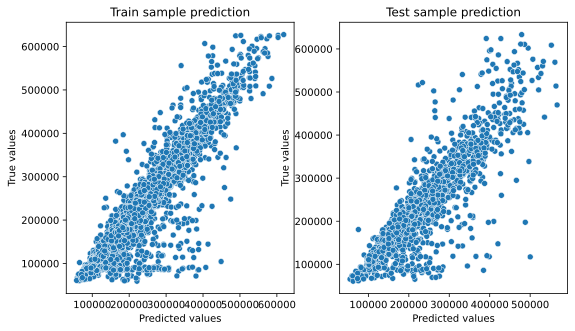

In [77]:
evaluate_preds(y_train, y_pred_train, y_valid, y_pred_valid)

#### Кросс-валидация

In [78]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1)
cv_score

array([0.76071932, 0.72756361, 0.75810146])

In [79]:
cv_score.mean()

0.7487947950067707

#### Важность признаков

In [80]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
1,Square,0.140706
16,RoomSquare,0.120848
4,HouseYear,0.117987
0,DistrictId,0.105663
5,Ecology_1,0.071966
8,Social_2,0.071052
3,HouseFloor,0.068529
2,Floor,0.060836
7,Social_1,0.058587
10,Healthcare_1,0.046062


## Прогнозирование на тестовом датасете <a class='anchor' id='prediction'>

In [81]:
predictions = model.predict(test_df)

In [82]:
predictions = pd.DataFrame(predictions, index=test_df.index, columns=['Price'])

In [83]:
predictions.to_csv('./mrozov_prediction_2.csv')